In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook

In [2]:
# LIBRARIES #

import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

import SimpleITK as sitk

In [38]:
# INPUT PARAMETERS #
#m_filename = 'colli5_72dpi.tif'
m_filename = 'colli5_72dpi.tif'

# coefs R/B gray values:
m_coefX6 = 171495   #x6
m_coefX5 = -1191642  #x5
m_coefX4 = 3444427   #x4
m_coefX3 = -5304935  #x3
m_coefX2 = 4596466   #x2
m_coefX1 = -2128075  #x
m_coefX0 = 412540   #

"""# coefs R/B DO:
m_coefX6 = 0   #x6
m_coefX5 = 0  #x5
m_coefX4 = 0   #x4
m_coefX3 = 1774.1  #x3
m_coefX2 = -3907.8   #x2
m_coefX1 = 3276.7  #x
m_coefX0 = -935.12   #"""


m_dosemax = 350.0 #cGy

In [39]:
# GAFCHROMIC FILMS CLASS #

class GafchromicFilms:
    
    # Constructor
    #  filename: gafchromic tiff file to read
    def __init__(self, filename):
        self.sizex, self.sizey, self.img_origin, self.img_spacing, self.array = self.readImg(filename)
    
    # Reads the image
    #  filename: filename of the gafchromic tiff file to read
    def readImg(self,filename):
        img = sitk.ReadImage(filename)
        sizex = img.GetWidth()
        sizey = img.GetHeight()
        imgOrigin = img.GetOrigin()
        imgSpacing = img.GetSpacing()
        array = sitk.GetArrayFromImage(img)
        return sizex, sizey, imgOrigin, imgSpacing, array
    
    
    # Converts the gafchromic image to dose using the optical density of red over blue channels and a polynomial 
    #  conversion curve (4th degree)
    #  coefs: calibration curve coefficients
    #  dosemax: maximum dose over which the dose is not calculated
    def convertToDose_polynomeLogRB(self, coefs, dosemax):
        # replaces every 65535 value in array with 65534 to avoid division by zero:
        self.array[self.array==65535]=65534
        
        # converts in optical density
        dor = -np.log10(self.array[:,:,0]/65535.0)
        dob = -np.log10(self.array[:,:,2]/65535.0)
    
        # red channel over blue channel:
        rsb = dor/dob

        # converting in dose:
        doseimg = coefs[0]*rsb**6 + coefs[1]*rsb**5 + coefs[2]*rsb**4 + coefs[3]*rsb**3 + coefs[4]*rsb**2 + coefs[5]*rsb + coefs[6]
        doseimg[doseimg>dosemax] = dosemax
        doseimg[doseimg<0] = 0
        
        return doseimg
    
    
    # Converts the gafchromic image to dose using the red over blue pixel values and a polynomial 
    #  conversion curve (3rd degree)
    #  coefs: calibration curve coefficients
    #  dosemax: maximum dose over which the dose is not calculated
    def convertToDose_polynomeGreyValueRB(self, coefs, dosemax):
        # replaces every 65535 value in array with 65534 to avoid division by zero:
        self.array[self.array==65535]=65534
        
        # red channel over blue channel:
        rsb = self.array[:,:,0]/self.array[:,:,2]

        # converting in dose:
        doseimg = coefs[0]*rsb**6 + coefs[1]*rsb**5 + coefs[2]*rsb**4 + coefs[3]*rsb**3 + coefs[4]*rsb**2 + coefs[5]*rsb + coefs[6]
        doseimg[doseimg>dosemax] = dosemax
        doseimg[doseimg<0] = 0
        
        return doseimg
    
    
    # Converts the gafchromic image to dose using the red and blue channels and a linear 
    #  fitting curve between all sampled points
    #  points: table of all sampled dose points
    #  dosemax: maximum dose over which the dose is not calculated
    def convertToDose_linear(self, points, dosemax):
        doseimg = self.array
        # to do...
        return doseimg
    
    
    # Saves the dose image to a tiff file that can be read using Verisoft
    # doseimg: img to save
    # filename: filename the dose img will be written to
    def saveToTiff(self, doseimg, filename):
        imagetif = sitk.Image([doseimg.shape[1],doseimg.shape[0]], sitk.sitkVectorUInt16, 3)
        imagetif.SetSpacing(self.img_spacing)
        imagetif.SetOrigin(self.img_origin)
        for j in range(0, doseimg.shape[0]):
            for i in range(0, doseimg.shape[1]):
                a = int(doseimg[j,i])
                imagetif.SetPixel(i,j,[a, a, a])
        
        writer = sitk.ImageFileWriter()
        writer.SetFileName(filename)
        writer.Execute(imagetif)
        return True

    
 

Center of mass: 43 39


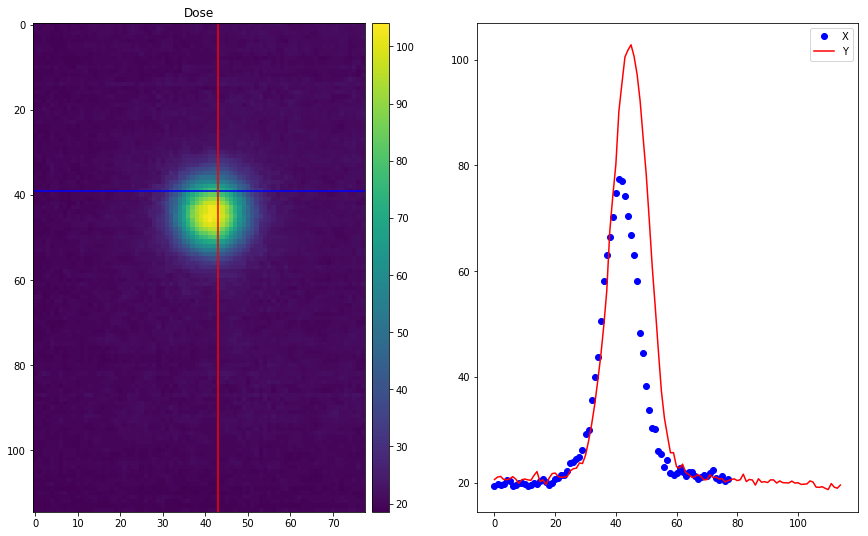

In [40]:
# PLOTS THE DOSE IMAGE #

coefs = [m_coefX6, m_coefX5, m_coefX4, m_coefX3, m_coefX2, m_coefX1, m_coefX0]

film = GafchromicFilms(m_filename)
doseimg = film.convertToDose_polynomeLogRB(coefs, m_dosemax)
doseimg = film.convertToDose_polynomeGreyValueRB(coefs, m_dosemax)
#film.saveToTiff(doseimg, '')

plt.rcParams['figure.figsize'] = (15,9)
fig = plt.figure()
gs = gridspec.GridSpec(1,2)

ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(doseimg)#, cmap="Greys", vmin = 0, vmax = 100)
ax1.set_title('Dose')
#ax1.axes.get_xaxis().set_visible(False)
#ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

com = ndimage.measurements.center_of_mass(doseimg[10:film.sizex-10,10:film.sizey-10])
comx = int(com[1])+10
comy = int(com[0])+10
print("Center of mass:", comx, comy)

linex = [0,film.sizex]
liney = [comy,comy]
line1 = plt.Line2D(linex, liney, color='b')
ax1.add_line(line1)
linex = [comx,comx]
liney = [0,film.sizey]
line2 = plt.Line2D(linex, liney, color='r')
ax1.add_line(line2)

ax2 = fig.add_subplot(gs[1])
im2 = ax2.plot(doseimg[comy,:], 'bo', label='X')
im2 = ax2.plot(doseimg[:,comx], 'r-', label='Y')
ax2.legend()

try:
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax1)
except:
    print('Error displaying images side bars')